<a href="https://colab.research.google.com/github/Praneeth-18/DataMining6/blob/main/Audio_Embeddings_using_Imagebind_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To generate and utilize audio embeddings, first, convert the audio into a spectrogram (a visual representation), and then use the LLM to generate embeddings from these spectrograms. This approach leverages the image understanding capabilities of LLMs for audio data.

In [1]:
!pip install transformers torchaudio librosa matplotlib

In [2]:
import torchaudio
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel

In [3]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [5]:
# Example audio file
audio_file = '/content/drive/MyDrive/CMPE-256 files/Audio from NASA’s Juno Mission_ Europa Flyby.mp3'

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


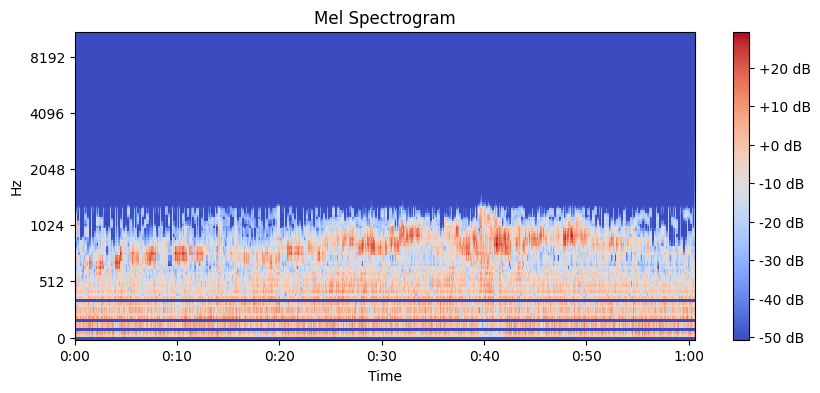

In [6]:
def audio_to_spectrogram(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)
    return librosa.power_to_db(spectrogram.numpy())

spectrogram = audio_to_spectrogram(audio_file)

# Plotting the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram[0], sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [8]:
from PIL import Image

In [11]:
def get_clip_embeddings_from_spectrogram(spectrogram):
    # Normalize the spectrogram
    norm_spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

    # Convert to a format suitable for PIL (grayscale, 2D)
    norm_spectrogram = (norm_spectrogram * 255).astype(np.uint8)
    norm_spectrogram = np.squeeze(norm_spectrogram)  # Ensure it's 2D

    image = Image.fromarray(norm_spectrogram, mode='L')  # 'L' mode for grayscale
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs

In this setup, audio files are first converted into spectrograms, which are then fed into a pre-trained CLIP model to obtain embeddings. This approach allows you to leverage image-based LLMs for audio analysis tasks.

# **Embeddings:**

In [17]:
import librosa
import numpy as np

def augment_audio(y, sr):
    # Apply pitch shift
    y_pitch_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

    # Apply time stretch
    y_stretched = librosa.effects.time_stretch(y, rate=1.1)

    # Apply random noise
    noise = np.random.randn(len(y))
    y_noisy = y + 0.005 * noise

    return [y, y_pitch_shifted, y_stretched, y_noisy]

# Example usage
y, sr = librosa.load(audio_file)  # Load an audio file
augmented_audios = augment_audio(y, sr)

# Process each augmented audio as before to get more data points

In [19]:
import librosa

audio_file_path = '/content/drive/MyDrive/CMPE-256 files/Audio from NASA’s Juno Mission_ Europa Flyby.mp3'  # Replace with your audio file path
original_audio, sr = librosa.load(audio_file_path, sr=None)

In [21]:
def audio_to_spectrogram(audio, sample_rate):
    # Convert audio to mono if it's stereo
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)

    # Compute the Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    return spectrogram_db

In [22]:
all_embeddings = []

# Include the original audio in the list for processing
audio_list = [original_audio] + augmented_audios

for audio in audio_list:
    # Convert audio to a spectrogram
    spectrogram = audio_to_spectrogram(audio, sr)

    # Generate embeddings from the spectrogram
    embedding = get_clip_embeddings_from_spectrogram(spectrogram)
    all_embeddings.append(embedding)

# Convert list of embeddings to a numpy array
all_embeddings = np.vstack(all_embeddings)

## **Clustering:**

In [24]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 5  # Adjust based on your needs

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(all_embeddings)

# clusters will contain the cluster label for each audio sample

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [28]:
# Define the number of clusters
num_clusters = 3  # Adjust this based on your needs or exploration

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(all_embeddings)

# The 'clusters' array now holds the cluster assignment for each audio file

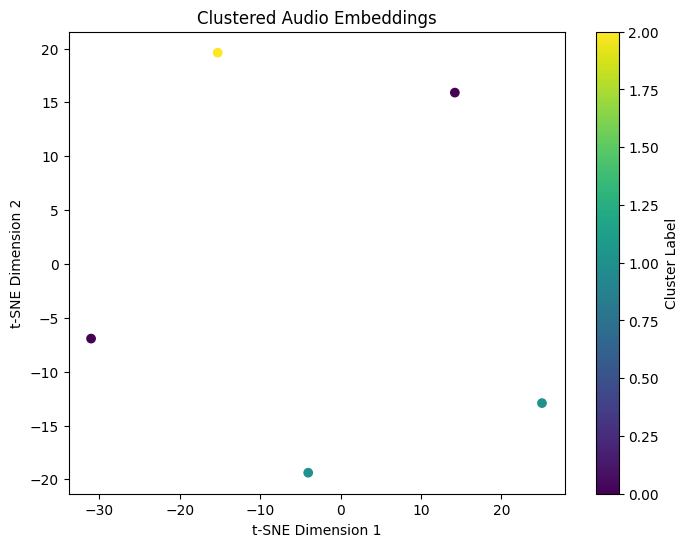

In [30]:
# Get the number of samples in your embeddings
num_samples = all_embeddings.shape[0]

# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, num_samples - 1)  # 30 is the default, reduce it if needed

# Use t-SNE with the adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis')
plt.title('Clustered Audio Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

This process clusters your audio data based on the features extracted and represented in the embeddings. The t-SNE visualization provides an intuitive way to see how the audio samples are grouped in the reduced dimensional space, which can be especially helpful for understanding the relationships and patterns in your data. The choice of the number of clusters (num_clusters) and other parameters can be fine-tuned based on the specific characteristics of your dataset and the objectives of your analysis.